In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

We want to first load in the words in our NRC Emotion Lexicon

In [281]:
emotions = dict()

with open('./NRC-Emotion-Lexicon/NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', 'r') as f:
    for line in f:
        emotion_lexicon = line.strip('\n')
        emotion_lexicon_entry = emotion_lexicon.split('\t')
        if emotion_lexicon_entry[0] not in emotions:
            emotions[emotion_lexicon_entry[0]] = dict()
        emotions[emotion_lexicon_entry[0]][emotion_lexicon_entry[1]] = int(emotion_lexicon_entry[2])

Load in the subreddit data files for specialized and generalized subreddits and combine them into one dataframe.

In [282]:
# load in specialized dataset
guitars_df = pd.read_csv('./data/specialized/negative_comments_guitars_w_replies.csv')
piano_df = pd.read_csv('./data/specialized/negative_comments_piano_w_replies.csv')
photography_df = pd.read_csv('./data/specialized/negative_comments_photography_w_replies.csv')

# combine into one dataframe
specialized_df = pd.concat([guitars_df, piano_df, photography_df])

In [283]:
# load in generalized dataset
askReddit_df = pd.read_csv('./data/generalized/negative_comments_AskReddit_w_replies.csv')
funny_df = pd.read_csv('./data/generalized/negative_comments_funny_w_replies.csv')
todayilearned_df = pd.read_csv('./data/generalized/negative_comments_todayilearned_w_replies.csv')

# combine into one dataframe
generalized_df = pd.concat([askReddit_df, funny_df, todayilearned_df])

First pre-processing that we need to do is to get rid of entries where there are no replies. This is because they will not help us answer our questions regarding the sentiment of replies.

In [284]:
specialized_df_wo_empty_replies = specialized_df[specialized_df['reply'].notna()]
generalized_df_wo_empty_replies = generalized_df[generalized_df['reply'].notna()]

#### 1. How do replies to negatively voted comments differ in attitude between specialized and generalized communities?


Now we will move on to getting the emotion scores for each comment and their reply. We will do so by using the NRC Emotion Lexicon.

In [285]:
def get_emotion_scores(comment):
    # first tokenize the comment body
    tokens = word_tokenize(comment)

    # get emotion scores for each token
    comment_emotions = []
    for token in tokens:
        if token in emotions:
            comment_emotions.append(emotions[token])
    
    # now we want to add up the emotion scores for each comment and reply
    comment_emotion_score = dict()
    for scores in comment_emotions:
        for emotion, score in scores.items():
            if emotion not in comment_emotion_score:
                comment_emotion_score[emotion] = 0
            comment_emotion_score[emotion] += score

    return comment_emotion_score



We want to run the above function for every comment reply pair, and then store the results in a dataframe.

In [286]:
def get_emotions_df(df):
    comments = df['body'].tolist()
    replies = df['reply'].tolist()

    # get emotions for comments and replies in df
    comment_emotion = []
    reply_emotion = []
    for i in range(len(comments)):
        comment_emotion.append(get_emotion_scores(comments[i]))
        reply_emotion.append(get_emotion_scores(replies[i]))

    # create dfs from emotions lists
    comment_emotions_df = pd.DataFrame(comment_emotion)
    reply_emotions_df = pd.DataFrame(reply_emotion)
    emotions_df = comment_emotions_df.merge(reply_emotions_df, left_index=True, right_index=True, suffixes=('_comment', '_reply'))

    return emotions_df.dropna(), comment_emotions_df.dropna(), reply_emotions_df.dropna()
    

In [287]:
# get the combined emotion dataframe, comment emotion dataframe, and reply emotion dataframe for specialized and generalized datasets
sp_emotions_df, sp_comment_emotions_df, sp_reply_emotions_df = get_emotions_df(specialized_df_wo_empty_replies)
g_emotions_df, g_comment_emotions_df, g_reply_emotions_df = get_emotions_df(generalized_df_wo_empty_replies)

In [288]:
# get the sums of each emotion for the replies in the specialized and generalized datasets
sp_reply_emotion_sums = sp_reply_emotions_df.drop(['positive', 'negative'], axis=1).sum().sort_values(ascending=False)
g_reply_emotion_sums = g_reply_emotions_df.drop(['positive', 'negative'], axis=1).sum().sort_values(ascending=False)

In [289]:
# get the sums of each polarity for the replies in the specialized and generalized datasets
sp_reply_polarity = sp_reply_emotions_df[['positive', 'negative']].sum().sort_values(ascending=False)
g_reply_polarity = g_reply_emotions_df[['positive', 'negative']].sum().sort_values(ascending=False)

In [290]:
# since we want consistent colors for emotions for all our graphs, we will assign a color to each emotion
emotion_color_map = {'trust': 'cornflowerblue', 'anticipation': 'orange', 'joy': 'palegreen', 'fear': 'orangered', 'anger': 'violet', 'disgust': 'grey', 'sadness': 'peachpuff', 'surprise': 'pink'}

# get the colors for each emotion for the specialized and generalized datasets
sp_emotion_colors = [emotion_color_map[label] for label in sp_reply_emotion_sums.index]
g_emotion_colors = [emotion_color_map[label] for label in g_reply_emotion_sums.index]

Text(0.5, 1.0, 'Specialized Subreddits Reply Polarity Sums')

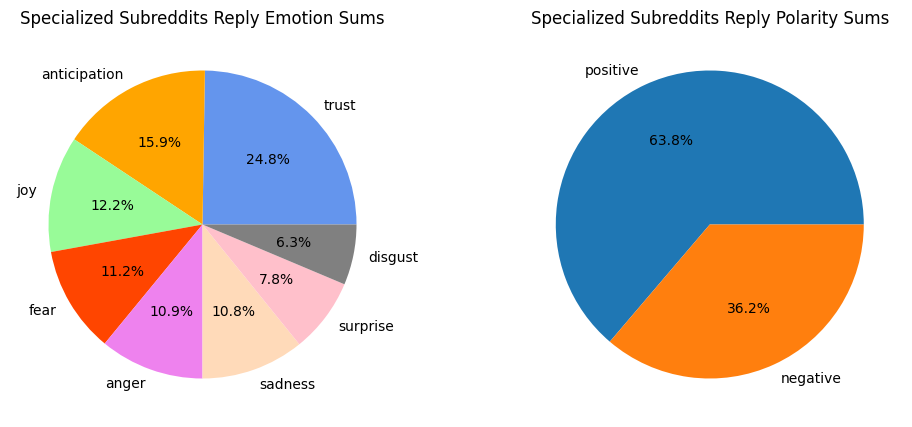

In [291]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pie(sp_reply_emotion_sums.values, labels=sp_reply_emotion_sums.index, autopct='%1.1f%%', colors=sp_emotion_colors)
plt.title("Specialized Subreddits Reply Emotion Sums")

plt.subplot(1,2,2)
plt.pie(sp_reply_polarity.values, labels=sp_reply_polarity.index, autopct='%1.1f%%')
plt.title("Specialized Subreddits Reply Polarity Sums")

Here the ordering of the emotions is as follows: trust, anticipation, joy, fear, anger, sadness, surprise, and disgust.
We also notice that the sum of positive emotions is roughly double that of the sum of negative emotions.

Text(0.5, 1.0, 'Generalized Subreddits Reply Polarity Sums')

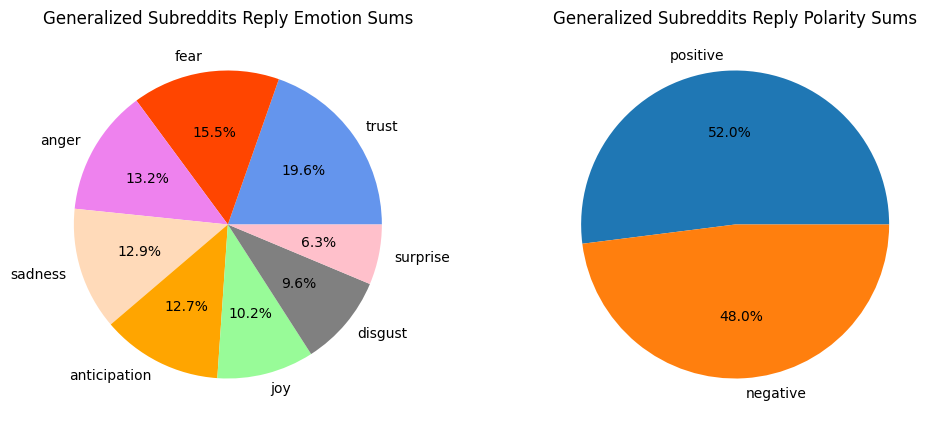

In [292]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pie(g_reply_emotion_sums.values, labels=g_reply_emotion_sums.index, autopct='%1.1f%%', colors=g_emotion_colors)
plt.title("Generalized Subreddits Reply Emotion Sums")

plt.subplot(1,2,2)
plt.pie(g_reply_polarity.values, labels=g_reply_polarity.index, autopct='%1.1f%%')
plt.title("Generalized Subreddits Reply Polarity Sums")

Here, the ordering of emotions is as follows: trust, fear, anger, sadness, anticipation, joy, disgust and surprise.
We also see that positive emotions and negative emotions have roughly the same sum.

From the above graphs, we can make some conclusions.

Looking at the Emotion Sums graphs for the specialized and generalized communities, we can see that specialized communities have a higher percentage of "positive" emotions such as "anticipation" and "joy", whereas generalized communities have a higher percentage of "negative" emotions such as "anger", "fear" and "sadness". 

We can also look at the Polarity Sums graph for the two types of communities, and we can see that specialized communities have a higher percentage of "positive" polarity for their comment replies than generalized communities (where the split is more even).

From this, we can conlude that specialized communities have a higher percentage of "positive" emotions and polarity in their comment replies than generalized communities.

#### 2. How do the attitudes of the replies relate to the attitudes of the initial comment?


Now we want to explore the relationship between a comment's emotion score and its reply's emotion score. Primarily, we want to explore how a comment's emotion score will influence the reply's emotion score within these two communities.

We can do this by calculating the frequency with which each emotion in a comment appears with an emotion in a reply. We will first do this for the generalized communities

In [293]:
# these labels will help us in calculating the emotion and polarity frequencies.
emotion_labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
polarity_labels = ['positive', 'negative']

In [294]:
# this function will add in the keys to the total_emotion_freq and total_polarity_freq dictionaries
def init_freq_dicts():
    total_emotion_freq = dict()
    total_polarity_freq = dict()

    # initialize frequency dictionaries
    # add all the emotion labels as keys
    for label in emotion_labels:
        total_emotion_freq[label] = dict()
        for emotion in emotion_labels:
            total_emotion_freq[label][emotion] = 0

    # add all the polarity labels as keys
    for label in polarity_labels:
        total_polarity_freq[label] = dict()
        for polarity in polarity_labels:
            total_polarity_freq[label][polarity] = 0

    return total_emotion_freq, total_polarity_freq

In [295]:
# initialize the frequency dictionaries
total_emotion_freq, total_polarity_freq = init_freq_dicts()

In [296]:
# calculate the emotion and polarity frequencies for each row in the specialized and generalized datasets
def calculate_freq(row):
    freq = dict()

    # if the comment has a polarity with a value greater than 0
    # and the reply has a polarity with a value greater than 0
    # we will increment this polarity pair count
    for comment_label in polarity_labels:
        if row[comment_label + '_comment'] > 0:

            for reply_label in polarity_labels:
                if row[reply_label + '_reply'] > 0:
                    total_polarity_freq[comment_label][reply_label] += 1

    # we will do a similar operation for the emotions
    for comment_label in emotion_labels:
        # if the comment has an emotion, we will check emotion of replies
        if row[comment_label + '_comment'] > 0:
            if comment_label not in freq:
                freq[comment_label] = dict()
            for reply_label in emotion_labels:
                # if the reply has an emotion, we will increment its count
                if row[reply_label + '_reply'] > 0:
                    if reply_label not in freq[comment_label]:
                        freq[comment_label][reply_label] = 0
                    freq[comment_label][reply_label] += 1
                    total_emotion_freq[comment_label][reply_label] += 1
    
    return freq

In [297]:
# get the emotion frequency for generalized dataset
g_comment_reply_emotion_freq = g_emotions_df.apply(calculate_freq, axis=1)

In [298]:
# we will convert the total emotion and polarity frequencies into dataframes
g_polarity_freq_df = pd.DataFrame(total_polarity_freq)
g_emotion_freq_df = pd.DataFrame(total_emotion_freq)

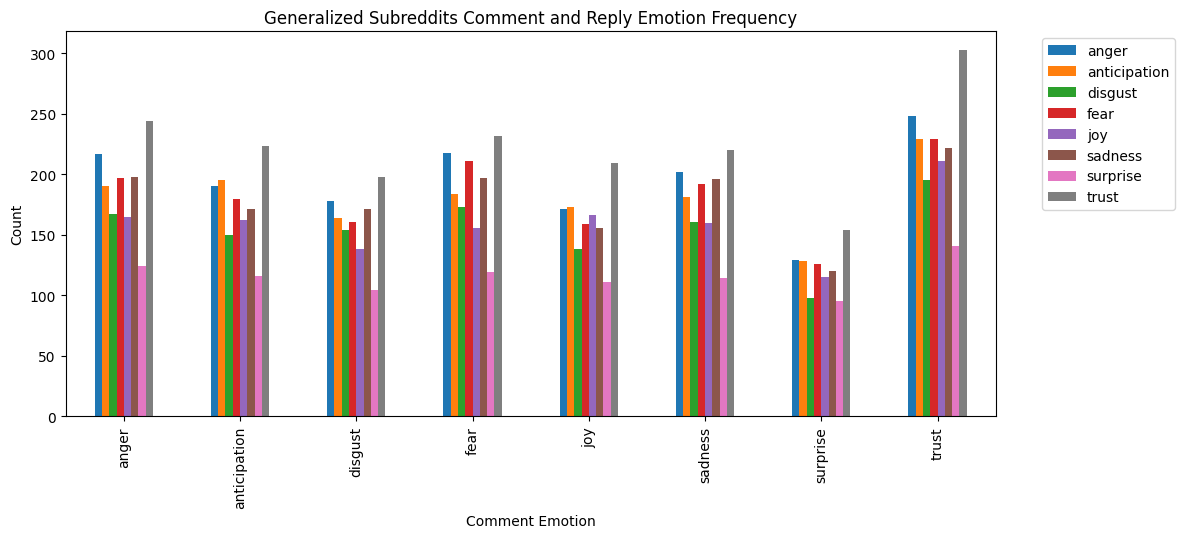

In [299]:
g_emotion_freq_plot = g_emotion_freq_df.plot(kind='bar', figsize=(12,5))
g_emotion_freq_plot.set_xlabel("Comment Emotion")
g_emotion_freq_plot.set_ylabel("Count")
g_emotion_freq_plot.set_title("Generalized Subreddits Comment and Reply Emotion Frequency")
g_emotion_freq_plot.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

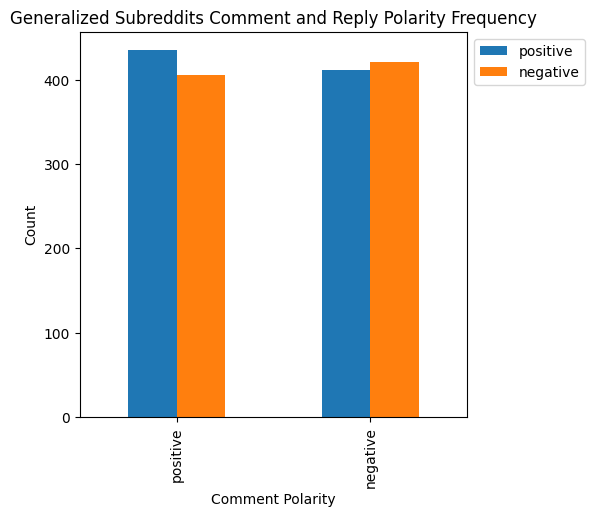

In [300]:
g_polarity_freq_plot = g_polarity_freq_df.plot(kind='bar', figsize=(5,5))
g_polarity_freq_plot.set_xlabel("Comment Polarity")
g_polarity_freq_plot.set_ylabel("Count")
g_polarity_freq_plot.set_title("Generalized Subreddits Comment and Reply Polarity Frequency")
g_polarity_freq_plot.legend(loc='upper left', bbox_to_anchor=(1, 1))

Now we will conduct the same process for the specialized communities

In [301]:
# reinitialize the frequency dictionaries
total_emotion_freq, total_polarity_freq = init_freq_dicts()

In [302]:
# get the emotion frequency for generalized dataset
sp_comment_reply_emotion_freq = sp_emotions_df.apply(calculate_freq, axis=1)

# convert the total emotion and polarity frequencies into dataframes
sp_polarity_freq_df = pd.DataFrame(total_polarity_freq)
sp_emotion_freq_df = pd.DataFrame(total_emotion_freq)

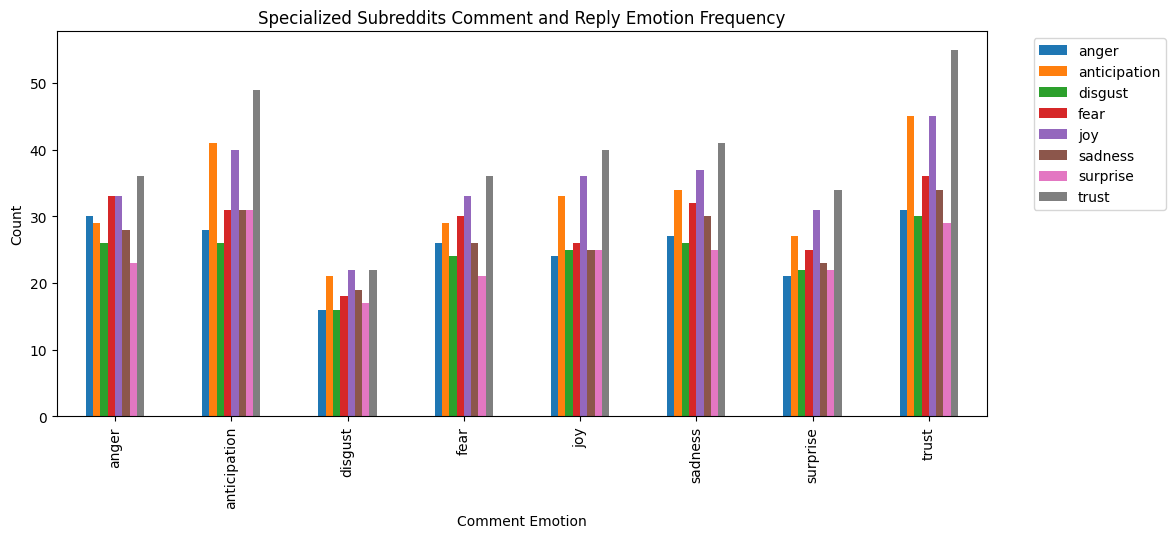

In [303]:
sp_emotion_freq_plot = sp_emotion_freq_df.plot(kind='bar', figsize=(12,5))
sp_emotion_freq_plot.set_xlabel("Comment Emotion")
sp_emotion_freq_plot.set_ylabel("Count")
sp_emotion_freq_plot.set_title("Specialized Subreddits Comment and Reply Emotion Frequency")
sp_emotion_freq_plot.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

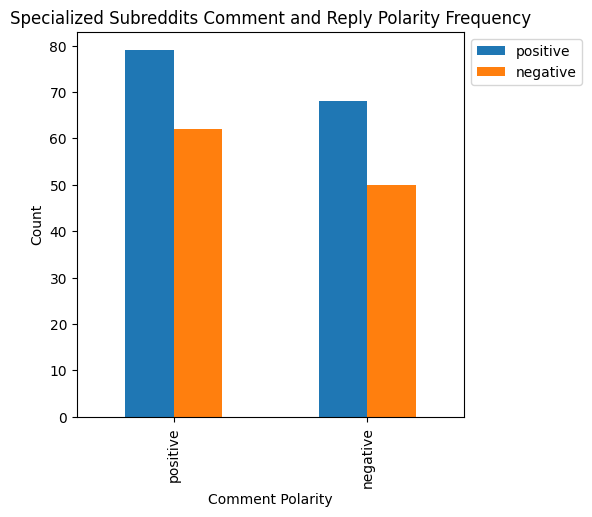

In [304]:
sp_polarity_freq_plot = sp_polarity_freq_df.plot(kind='bar', figsize=(5,5))
sp_polarity_freq_plot.set_xlabel("Comment Polarity")
sp_polarity_freq_plot.set_ylabel("Count")
sp_polarity_freq_plot.set_title("Specialized Subreddits Comment and Reply Polarity Frequency")
sp_polarity_freq_plot.legend(loc='upper left', bbox_to_anchor=(1, 1))

#### 3. How do the attitudes differ in replies to positively voted comments?

In [305]:
# load in positive comments and replies dataset for specialized subreddits
pos_piano_df = pd.read_csv('./data/specialized/positive_comments_piano_w_replies.csv')
pos_guitars_df = pd.read_csv('./data/specialized/positive_comments_guitars_w_replies.csv')
pos_photography_df = pd.read_csv('./data/specialized/positive_comments_photography_w_replies.csv')

# combine into one dataframe and drop rows that contain NA values
sp_pos_df = pd.concat([pos_piano_df, pos_guitars_df, pos_photography_df])
sp_pos_df = sp_pos_df.dropna()

In [306]:
# load in positive comments and replies dataset for generalized subreddits
pos_askReddit_df = pd.read_csv('./data/generalized/positive_comments_AskReddit_w_replies.csv')
pos_funny_df = pd.read_csv('./data/generalized/positive_comments_funny_w_replies.csv')
pos_todayilearned_df = pd.read_csv('./data/generalized/positive_comments_todayilearned_w_replies.csv')

# combine into one dataframe and drop rows that contain NA values
g_pos_df = pd.concat([pos_askReddit_df, pos_funny_df, pos_todayilearned_df])
g_pos_df = g_pos_df.dropna()

In [308]:
# get the emotion dataframes for the positive comments and replies for both specialized and generalized datasets
g_pos_emotions_df, g_pos_comment_emotions_df, g_pos_reply_emotions_df = get_emotions_df(g_pos_df)
sp_pos_emotions_df, sp_pos_comment_emotions_df, sp_pos_reply_emotions_df = get_emotions_df(sp_pos_df)

In [310]:
# get the sums of each emotion for the replies in the specialized and generalized datasets
sp_pos_reply_emotion_sums = sp_pos_reply_emotions_df.drop(['positive', 'negative'], axis=1).sum().sort_values(ascending=False)
g_pos_reply_emotion_sums = g_pos_reply_emotions_df.drop(['positive', 'negative'], axis=1).sum().sort_values(ascending=False)

# get the sums of each polarity for the replies in the specialized and generalized datasets
sp_pos_reply_polarity = sp_pos_reply_emotions_df[['positive', 'negative']].sum().sort_values(ascending=False)
g_pos_reply_polarity = g_pos_reply_emotions_df[['positive', 'negative']].sum().sort_values(ascending=False)

In [312]:
# to keep the colors consistent, we will use the same color map as before
sp_pos_emotion_colors = [emotion_color_map[label] for label in sp_pos_reply_emotion_sums.index]
g_pos_emotion_colors = [emotion_color_map[label] for label in g_pos_reply_emotion_sums.index]

Text(0.5, 1.0, 'Specialized Subreddits Reply Polarity Sums')

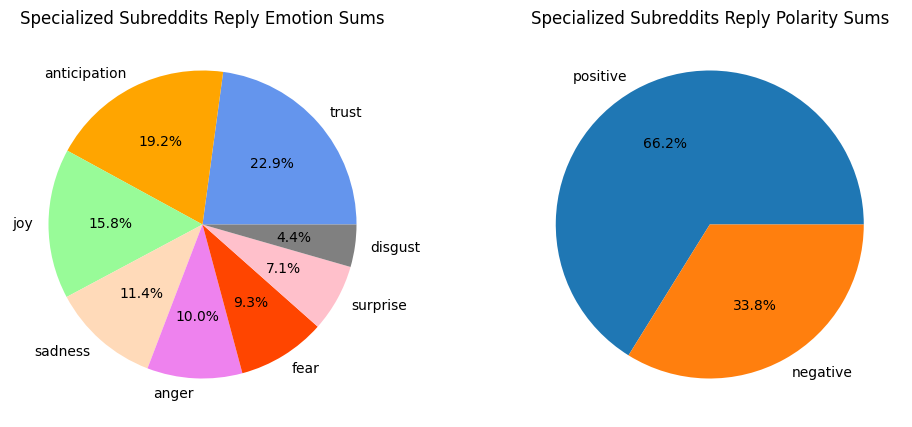

In [313]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pie(sp_pos_reply_emotion_sums.values, labels=sp_pos_reply_emotion_sums.index, autopct='%1.1f%%', colors=sp_pos_emotion_colors)
plt.title("Specialized Subreddits Reply Emotion Sums")

plt.subplot(1,2,2)
plt.pie(sp_pos_reply_polarity.values, labels=sp_pos_reply_polarity.index, autopct='%1.1f%%')
plt.title("Specialized Subreddits Reply Polarity Sums")

Text(0.5, 1.0, 'Generalized Subreddits Reply Polarity Sums')

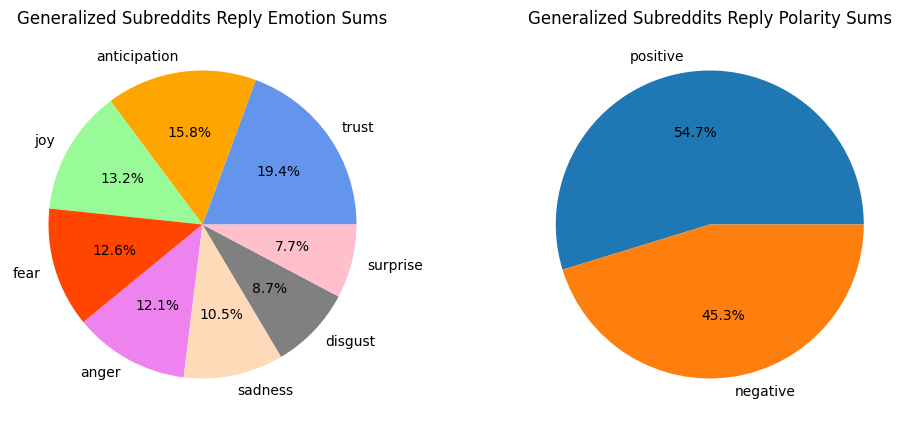

In [314]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pie(g_pos_reply_emotion_sums.values, labels=g_pos_reply_emotion_sums.index, autopct='%1.1f%%', colors=g_pos_emotion_colors)
plt.title("Generalized Subreddits Reply Emotion Sums")

plt.subplot(1,2,2)
plt.pie(g_pos_reply_polarity.values, labels=g_pos_reply_polarity.index, autopct='%1.1f%%')
plt.title("Generalized Subreddits Reply Polarity Sums")